In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform

In [37]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

class LennardJones():
    def __init__(self, eps0=5, sigma=2**(-1/6)):
        self.eps0 = eps0
        self.sigma = sigma

    def _V(self, r):
        return 4 * self.eps0 * ((self.sigma / r)**12 - (self.sigma / r)**6)

    def _force(self, r):
        return 48 * self.eps0 * np.power(self.sigma, 12) / np.power(r, 13) - 24 * self.eps0 * np.power(self.sigma, 6) / np.power(r, 7)

    def LJ_force(self, pos):
        # Ensure pos is 2D
        pos = np.atleast_2d(pos)

        # Calculate pairwise distances between atoms
        distances = squareform(pdist(pos))
        forces = np.zeros_like(pos, dtype=np.float64)  # Ensure forces are float64

        # Loop over each pair of atoms
        for i in range(len(pos)):
            for j in range(len(pos)):
                if i != j:
                    r_vec = pos[i] - pos[j]
                    r = np.linalg.norm(r_vec)
                    if r > 0:  # Avoid division by zero
                        force = 24 * (2 / r**14 - 1 / r**8) * r_vec
                        forces[i] += force
        return forces

    def energy(self, pos):
        return np.sum(self._V(pdist(pos)))

    def fixed_atoms(self, fixed_atoms):
        self.fixed_atoms = fixed_atoms

    def dynamic_atoms(self, dynamic_atoms=np.array([[1, 0], [-1, 0]], dtype=np.float64)):
        self.dynamic_atoms = dynamic_atoms

    def move(self, area):
        self.area = area
        self.fixed_atoms
        self.xs = np.linspace(-self.area, self.area, 100)
        self.ys = np.linspace(-self.area, self.area, 100)
        self.energies = np.zeros((len(self.xs), len(self.ys)))
        for i in range(len(self.xs)):
            for j in range(len(self.ys)):
                self.energies[i, j] = self.energy(np.concatenate([self.fixed_atoms, np.array([[self.xs[i], self.ys[j]]])]))
        return self.energies

    def contour_plot(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        levels = np.arange(-20, 0.0001, 0.25)
        contour1 = ax.contour(self.xs, self.ys, self.energies, levels, cmap='autumn')
        contourf1 = ax.contourf(self.xs, self.ys, self.energies, levels, cmap='autumn', alpha=0.5)
        fig.colorbar(contourf1, ax=ax)

    def metropolis_LJ(self, samples, T, Delta_x=0.3):
        # Metropolis algorithm (not relevant for Velocity-Verlet integration)
        pass

    def plot_samples(self):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].scatter(self.dynamic_atoms[:, 0], self.dynamic_atoms[:, 1], c='blue', s=1000)
        ax[0].scatter(self.fixed_atoms[:, 0], self.fixed_atoms[:, 1], c='orange', s=1000)
        ax[0].set_title('E = ' + str(self.energy(np.concatenate((self.fixed_atoms, self.dynamic_atoms)))))

        ax[1].scatter(self.dynamic_atoms[:, 0], self.dynamic_atoms[:, 1], c='blue', s=1000)
        ax[1].scatter(self.fixed_atoms[:, 0], self.fixed_atoms[:, 1], c='orange', s=1000)
        ax[1].set_title('E = ' + str(self.energy(np.concatenate((self.fixed_atoms, self.dynamic_atoms)))))

        for i in range(2):
            ax[i].set_xlim(-2, 2)
            ax[i].set_ylim(-2, 2)

    @property
    def kinetic_energy(self):
        return 0.5 * np.sum(self.velocities**2)
    
    def set_velocities(self, velocities):
        self.velocities = velocities

    def get_velocities(self):
        return self.velocities.copy()




In [90]:
#Andrea-Anderson thermostat:
def thermostat(m,T, shape):
    v = np.random.normal(0, np.sqrt(T/m), shape)
    return v


In [119]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
plot_energies_KT = []

class VelocityVerlet:
    def __init__(self, dt):
        self.dt = dt
        self.position_history = []  # To store positions at each timestep
        self.velocity_history = []  # To store velocities at each timestep

    def velocity_verlet(self, lj_system, positions, velocities):
        positions = positions.astype(np.float64)
        velocities = velocities.astype(np.float64)

        # Get forces and calculate accelerations
        forces = lj_system.LJ_force(positions)
        accelerations = forces / 1.0  # Assuming unit mass

        # Update positions
        positions += velocities * self.dt + 0.5 * accelerations * self.dt**2

        # Calculate new forces and accelerations
        new_forces = lj_system.LJ_force(positions)
        new_accelerations = new_forces / 1.0  # Assuming unit mass

        # Update velocities
        velocities += 0.5 * (accelerations + new_accelerations) * self.dt

        # Save positions and velocities to history
        self.position_history.append(positions.copy())
        self.velocity_history.append(velocities.copy())

        return positions, velocities

    def get_position_history(self):
        return np.array(self.position_history)

    def get_velocity_history(self):
        return np.array(self.velocity_history)

# Animation function using FuncAnimation
def animate_trajectories(lj_system, verlet):
    position_history = verlet.get_position_history()
    velocity_history = verlet.get_velocity_history()

    # Setup the plot
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    
    # Plot fixed atoms
    # ax.scatter(lj_system.fixed_atoms[:, 0], lj_system.fixed_atoms[:, 1], color='orange', s=100, label="Fixed Atoms")
    
    # Limits for the axes
    ax[0].set_xlim(-5, 5)
    ax[0].set_ylim(-5, 5)
    ax[0].grid()
    ax[1].grid()
    ax[1].set_xlim(0, 1000)
    ax[1].set_ylim(-20, 20)


    
    # Plot dynamic atoms that will be updated in the animation
    dynamic_atoms_plot, = ax[0].plot([], [], 'bo', markersize=10, label='Dynamic Atoms')
    energy_plot, = ax[1].plot([], [], 'r-', label='Energy')
    line, = ax[1].plot([], [], 'grey', lw=2)
    
    # Set labels
    # ax.set_xlabel('X position')
    # ax.set_ylabel('Y position')

    # Initialization function for the animation
    def init():
        dynamic_atoms_plot.set_data([], [])
        line.set_data([], [])
        return dynamic_atoms_plot, line

    # Update function for each frame of the animation
    plot_energies = []
    def update(frame):
        # Get positions and velocities for the current frame
        positions = position_history[frame]
        velocities = velocity_history[frame]

        # Set dynamic atom positions
        dynamic_atoms_plot.set_data(positions[:, 0], positions[:, 1])

        # Calculate kinetic energy
        kinetic_energy = 0.5 * np.sum(velocities**2)

        # Calculate potential energy
        potential_energy = lj_system.energy(((positions)))

        # Update the plot title with total kinetic and potential energy
        total_energy = kinetic_energy + potential_energy
        ax[0].set_title(f'kT = {kt} | Frame {frame} | KE: {kinetic_energy:.1f} | PE: {potential_energy:.1f} | Total E: {total_energy:.1f}')

        # Update the energy plot
        plot_energies.append(total_energy)
        line.set_data(range(len(plot_energies)), plot_energies)
        
        
        return dynamic_atoms_plot, line

    # Create animation and assign it to a variable (ani)
    ani = FuncAnimation(fig, update, frames=range(len(position_history)), 
                    init_func=init, blit=True, interval=1, repeat=False)
    
    # plt.legend()
    ani.save(f"Velocity_verlet_3_{kt}.gif", writer="imagemagick", fps=30)


    # Show the animation
    plt.show()

    # The animation object (ani) now exists in the current scope
    plot_energies_KT.append(plot_energies)

    return ani

# Ensure that matplotlib is properly set for interactive environments
# For Jupyter, use: %matplotlib notebook
# In regular Python script, this is not needed.
%matplotlib notebook

# Example Usage:

# Instantiate Lennard-Jones and Velocity-Verlet classes
lj = LennardJones()
# fixed_input = np.array([[-2,0], [-1,0], [0,0], [1,0], [2,0]])

dynamic_input = np.array([[-0.5,0], [0.5,0], [0, np.sqrt(3)/2]])
# dynamic_input = np.array([[3.19973688, -1.95767492], [-3.19973688, -1.95767492], [0, np.sqrt(3)]])

# lj.fixed_atoms(fixed_input)
lj.dynamic_atoms(dynamic_input)

verlet = VelocityVerlet(dt=0.01)


# Initial velocities for dynamic atoms (e.g., random or zero)
# initial_velocities = np.random.rand(len(lj.dynamic_atoms), 2).astype(np.float64) * 0.1
initial_velocities = np.zeros_like(lj.dynamic_atoms)
# Simulate a few steps of motion and save the positions
for step in range(1000):  # More steps for smoother animation
    lj.dynamic_atoms, initial_velocities = verlet.velocity_verlet(lj, lj.dynamic_atoms, initial_velocities)
    if step % 50 == 0:
        initial_velocities = thermostat(1, kt, initial_velocities.shape)
        

    # Animate the trajectories
ani = animate_trajectories(lj, verlet)


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.
c:\Users\Sebastian Dahl\anaconda3\Lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


In [85]:
# initial_velocities = np.zeros_like(lj.dynamic_atoms)
initial_velocities

array([[-0.02153448, -0.01243294],
       [ 0.02153448, -0.01243294],
       [ 0.        ,  0.02486588]])

In [67]:
thermostat(0.5, 1, initial_velocities.shape)

array([[ 1.33785033,  1.37607822],
       [-3.00238787, -1.84261069],
       [ 0.6022514 ,  0.95069301]])

In [40]:
print("Position history shape:", verlet.get_position_history().shape)


Position history shape: (200, 3, 2)


In [107]:
position_history = verlet.get_position_history()
velocity_history = verlet.get_velocity_history()
print(f"Number of frames: {len(position_history)}, Expected: 200")

Number of frames: 1000, Expected: 200


In [159]:
%matplotlib inline
kts = [0.05, 0.1, 0.25, 0.5, 1, 2, 5]

plot_energies_KT
avg_energies = [np.mean(energies) for energies in plot_energies_KT]
C_V = [(avg_energies[i+1] - avg_energies[i]) / (kts[i+1] - kts[i]) for i in range(len(kts)-1)]



IndexError: list index out of range

In [151]:
C_V

[-4.069285542377266,
 5.364617465238174,
 6.097802382724485,
 3.359716421433843,
 1.9924961685863147,
 0.9354148305021622]

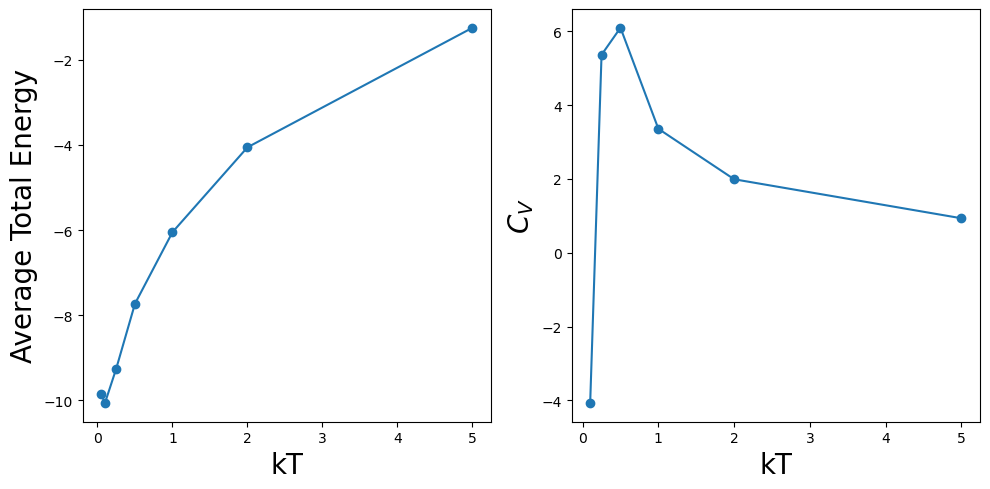

In [163]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot([0.05, 0.1, 0.25 ,0.5, 1, 2, 5], avg_energies, 'o-')
ax[0].set_xlabel('kT', fontsize=20)
ax[0].set_ylabel('Average Total Energy', fontsize=20)

ax[1].plot(kts[1:], C_V, 'o-')
ax[1].set_xlabel('kT', fontsize=20)
ax[1].set_ylabel(r'$C_V$', fontsize=20)
plt.tight_layout()

In [132]:
avg_energies = [np.mean(energies) for energies in plot_energies_KT]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([0.05, 0.1, 0.25, 0.5, 1, 2, 5], avg_energies, 'o-')
plt.xlabel("kT")
plt.ylabel("Average Energy")
plt.title("Average Energy vs kT")
plt.grid(True)
plt.show()


<IPython.core.display.Javascript object>